# ML: Match Winner Prediction

This notebook trains simple models to predict match winners using Elo features from `Data/ML_final.csv`. It creates a pairwise dataset (two examples per match), splits train/test, trains Logistic Regression and Random Forest, reports accuracy and confusion matrices, and writes a summary to `Data/ml_results.txt`.

In [3]:
import sys
sys.executable
print(f"Python executable path: {sys.executable}")

Python executable path: /Users/sanathshetty/Documents/Code San/DSProj/.venv/bin/python


In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
sns.set(style="whitegrid")
# Train models and evaluate (added baseline + XGBoost)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

In [5]:
# Load the ML dataset
csv_path = '../Data/ML_final.csv'
df = pd.read_csv(csv_path, low_memory=False)
print(f'Loaded rows: {len(df)}')
df = df.dropna(subset=['winner_elo','loser_elo']).reset_index(drop=True)
print(f'Rows with Elo: {len(df)}')

Loaded rows: 58502
Rows with Elo: 58502


In [6]:
# Build pairwise dataset
rows = []
for _, r in df.iterrows():
    try:
        w = float(r['winner_elo'])
        l = float(r['loser_elo'])
    except Exception:
        continue
    surface = r.get('surface') if 'surface' in r.index else None
    level = r.get('tourney_level') if 'tourney_level' in r.index else None
    rows.append({'elo_A': w, 'elo_B': l, 'elo_diff': w-l, 'surface': surface, 'tourney_level': level, 'label': 1})
    rows.append({'elo_A': l, 'elo_B': w, 'elo_diff': l-w, 'surface': surface, 'tourney_level': level, 'label': 0})
pairwise = pd.DataFrame(rows)
print(f'Pairwise examples: {len(pairwise)}')

Pairwise examples: 117004


In [7]:
# One-hot encode categories
for c in ['surface','tourney_level']:
    if c in pairwise.columns and pairwise[c].notna().any():
        d = pd.get_dummies(pairwise[c].fillna('NA'), prefix=c)
        pairwise = pd.concat([pairwise.drop(columns=[c]), d], axis=1)

# Features & label
X = pairwise[[col for col in pairwise.columns if col!='label']]
y = pairwise['label']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train:', len(X_train), 'Test:', len(X_test))

# Scale numerics
num_cols = [c for c in ['elo_A','elo_B','elo_diff'] if c in X_train.columns]
scaler = StandardScaler()
if num_cols:
    X_train.loc[:, num_cols] = scaler.fit_transform(X_train.loc[:, num_cols])
    X_test.loc[:, num_cols] = scaler.transform(X_test.loc[:, num_cols])

Train: 93603 Test: 23401


Baseline (elo_diff>0) Accuracy: 0.6660, ROC AUC: 0.665954327082863
              precision    recall  f1-score   support

           0     0.6651    0.6687    0.6669     11701
           1     0.6669    0.6632    0.6650     11700

    accuracy                         0.6660     23401
   macro avg     0.6660    0.6660    0.6660     23401
weighted avg     0.6660    0.6660    0.6660     23401



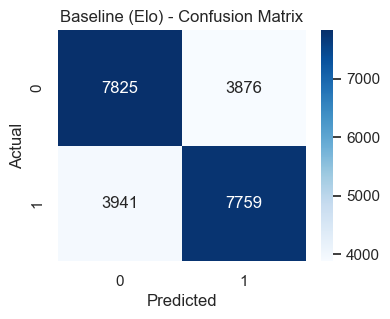

/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linea


Model: LogisticRegression
Accuracy: 0.6658, ROC AUC: 0.7314
              precision    recall  f1-score   support

           0     0.6647    0.6691    0.6669     11701
           1     0.6669    0.6625    0.6647     11700

    accuracy                         0.6658     23401
   macro avg     0.6658    0.6658    0.6658     23401
weighted avg     0.6658    0.6658    0.6658     23401



/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sanathshetty/Documents/Code San/DSProj/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

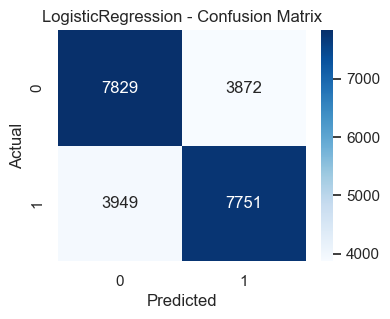


Model: RandomForest
Accuracy: 0.6148, ROC AUC: 0.6647
              precision    recall  f1-score   support

           0     0.6143    0.6169    0.6156     11701
           1     0.6152    0.6126    0.6139     11700

    accuracy                         0.6148     23401
   macro avg     0.6148    0.6148    0.6148     23401
weighted avg     0.6148    0.6148    0.6148     23401



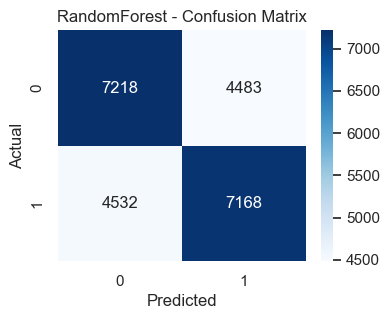


Model: XGBoost
Accuracy: 0.6565, ROC AUC: 0.7200
              precision    recall  f1-score   support

           0     0.6565    0.6565    0.6565     11701
           1     0.6565    0.6564    0.6564     11700

    accuracy                         0.6565     23401
   macro avg     0.6565    0.6565    0.6565     23401
weighted avg     0.6565    0.6565    0.6565     23401



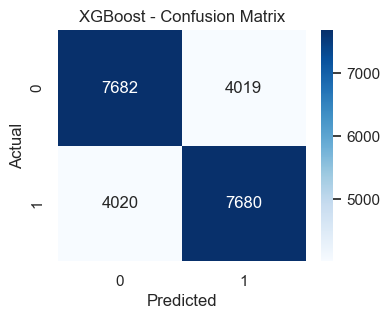

Saved ML results to Data/ml_results.txt


In [8]:

# Prepare models
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

# baseline: predict winner if elo_diff > 0 (use original elo_diff by inverse-scaling numeric cols)
X_test_orig = X_test.copy()
if 'elo_diff' in X_test_orig.columns and num_cols:
    try:
        X_test_orig.loc[:, num_cols] = scaler.inverse_transform(X_test.loc[:, num_cols])
    except Exception:
        # if inverse fails, try to use scaled values (still useful)
        pass

baseline_preds = (X_test_orig['elo_diff'] > 0).astype(int)
baseline_acc = accuracy_score(y_test, baseline_preds)
try:
    baseline_auc = roc_auc_score(y_test, baseline_preds)
except Exception:
    baseline_auc = float('nan')
print(f"Baseline (elo_diff>0) Accuracy: {baseline_acc:.4f}, ROC AUC: {baseline_auc if not pd.isna(baseline_auc) else 'nan'}")
print(classification_report(y_test, baseline_preds, digits=4))
cm_base = confusion_matrix(y_test, baseline_preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues')
plt.title('Baseline (Elo) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Fit LR and RF
lr.fit(X_train.fillna(0), y_train)
rf.fit(X_train.fillna(0), y_train)

# Try XGBoost
xgb_clf = None
try:
    xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, random_state=42, n_jobs=-1)
    xgb_clf.fit(X_train.fillna(0), y_train)
except Exception as e:
    print('XGBoost not available or failed to train:', e)

results = []
# Evaluate trained models
for name, model in [('LogisticRegression', lr), ('RandomForest', rf)]:
    preds = model.predict(X_test.fillna(0))
    proba = model.predict_proba(X_test.fillna(0))[:,1] if hasattr(model, 'predict_proba') else None
    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, proba) if proba is not None else float('nan')
    report = classification_report(y_test, preds, digits=4)
    cm = confusion_matrix(y_test, preds)
    print(f"\nModel: {name}")
    print(f"Accuracy: {acc:.4f}, ROC AUC: {auc:.4f}")
    print(report)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    results.append({'model': name, 'accuracy': acc, 'roc_auc': auc, 'classification_report': report})

# Evaluate XGBoost if present
if xgb_clf is not None:
    preds = xgb_clf.predict(X_test.fillna(0))
    proba = xgb_clf.predict_proba(X_test.fillna(0))[:,1] if hasattr(xgb_clf, 'predict_proba') else None
    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, proba) if proba is not None else float('nan')
    report = classification_report(y_test, preds, digits=4)
    cm = confusion_matrix(y_test, preds)
    print(f"\nModel: XGBoost")
    print(f"Accuracy: {acc:.4f}, ROC AUC: {auc:.4f}")
    print(report)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('XGBoost - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    results.append({'model': 'XGBoost', 'accuracy': acc, 'roc_auc': auc, 'classification_report': report})

# Include baseline in results
results.insert(0, {'model': 'Baseline_Elo', 'accuracy': baseline_acc, 'roc_auc': baseline_auc, 'classification_report': classification_report(y_test, baseline_preds, digits=4)})

# Save summary
with open('Data/ml_results.txt','w') as f:
    for r in results:
        f.write(f"Model: {r['model']}\n")
        f.write(f"Accuracy: {r['accuracy']:.4f}, ROC AUC: {r['roc_auc']:.4f}\n")
        f.write(r['classification_report'] + '\n')
print('Saved ML results to Data/ml_results.txt')

In [ ]:
# Rank-only baseline and comparison
import os
import pandas as pd

csv_path = '../Data/ML_final.csv'
if not os.path.exists(csv_path):
    print('ML_final.csv not found at', csv_path)
else:
    df = pd.read_csv(csv_path, low_memory=False)

    # Rank-only baseline (predict player with better/lower rank wins)
    rank_df = df.dropna(subset=['winner_rank', 'loser_rank']).copy()
    rank_df['winner_rank'] = pd.to_numeric(rank_df['winner_rank'], errors='coerce')
    rank_df['loser_rank'] = pd.to_numeric(rank_df['loser_rank'], errors='coerce')
    rank_df = rank_df.dropna(subset=['winner_rank','loser_rank'])
    rank_total = len(rank_df)
    if rank_total:
        rank_correct = (rank_df['winner_rank'] <= rank_df['loser_rank']).sum()
        rank_acc = rank_correct / rank_total
    else:
        rank_correct = 0
        rank_acc = float('nan')

    # Elo baseline (just in case)
    elo_df = df.dropna(subset=['winner_elo','loser_elo']).copy()
    elo_df['winner_elo'] = pd.to_numeric(elo_df['winner_elo'], errors='coerce')
    elo_df['loser_elo'] = pd.to_numeric(elo_df['loser_elo'], errors='coerce')
    elo_df = elo_df.dropna(subset=['winner_elo','loser_elo'])
    elo_total = len(elo_df)
    if elo_total:
        elo_correct = (elo_df['winner_elo'] >= elo_df['loser_elo']).sum()
        elo_acc = elo_correct / elo_total
    else:
        elo_correct = 0
        elo_acc = float('nan')

    # write summary file
    out_path = '../Data/ml_rank_baseline.txt'
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    with open(out_path, 'w') as fh:
        fh.write(f'Rank baseline: {rank_correct}/{rank_total} = {rank_acc:.6f}\n')
        fh.write(f'Elo baseline:  {elo_correct}/{elo_total} = {elo_acc:.6f}\n')
    print(f'Wrote baseline summary to {os.path.abspath(out_path)}')
    print(f'Rank baseline accuracy: {rank_acc:.4%} ({rank_correct}/{rank_total})')
    print(f'Elo baseline accuracy:  {elo_acc:.4%} ({elo_correct}/{elo_total})')

    # If results list exists (from this notebook run), print a compact comparison
    try:
        # 'results' is created earlier when models are evaluated in this notebook
        if 'results' in globals() and isinstance(results, list) and results:
            print('\nModel comparison:')
            for r in results:
                name = r.get('model', 'model')
                acc = r.get('accuracy', None)
                auc = r.get('roc_auc', None)
                print(f"- {name}: accuracy={acc:.4%} auc={auc if auc is not None else 'nan'}")
            # also show baseline from results if present
            for r in results:
                if r.get('model') == 'Baseline_Elo':
                    print(f"\nNotebook baseline (elo) reported: {r['accuracy']:.4%}")
                    break
        else:
            print('\nNo in-memory model results found in this notebook. Run the training cell to compute models and then re-run this cell to compare.')
    except Exception as e:
        print('Error while comparing with in-memory results:', e)
